
### Submitted By: Karthik Santhanam (AIML MAY Group - 3)¶
### Project: Advanced Computer Vision

### **PART - 1**

#### DOMAIN
Entertainment
#### CONTEXT
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
#### DATA DESCRIPTION
The dataset comprises of images and its mask where there is a human face.
#### PROJECT OBJECTIVE
Face detection from training images.

### Step 1.1 - Import the dataset.

Let us imports all required packages before importing dataset

In [1]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [3]:
# Initialize the random number generator
import random
random.seed(0)
tensorflow.random.set_seed(0)

from sklearn.model_selection import train_test_split

# NN Core imports
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

Let's import data set

In [4]:
project_path = "./Part-1"
train_datafile = project_path + './Part 1- Train data - images.npy'
test_image = project_path + './Part 1Test Data - Prediction Image.jpeg'

training_images = np.load(train_datafile, allow_pickle=True);
print ("Training images (training_images) data type -> ", type (training_images))
print ("Training images shape -> ", training_images.shape)

# Lets store the total images. This will be required to build test/train image batches
no_of_images = training_images.shape[0]

Training images (training_images) data type ->  <class 'numpy.ndarray'>
Training images shape ->  (409, 2)


Okay.. 
- We have got a multi dimensional array as input data. 
- Let us see what we have got by printing first element of our 2-d array.

In [5]:
training_images[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



In [6]:
print (type(training_images[0][0])) #-- Element 0 of 1st array element
print (type(training_images[0][1])) #-- Element 1 of 1st array element

<class 'numpy.ndarray'>
<class 'list'>


From above data printed for 1st element of input image data, we see that each element has,
1. Image itself (represented in an array)
2. Image cast information (represented by a list)

### Step 1.2 - Create features (images) and labels (mask) using that data.

Now, Let us extract image and mask information 

In [7]:
input_images = training_images[:,0]
input_masks = training_images[:,1]

Let us visualize and understand the data that we have got !

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

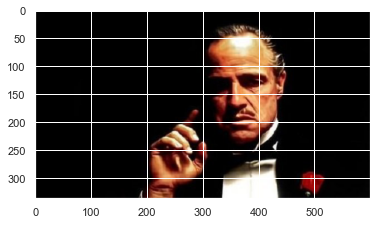

In [8]:
# Let us print one test image - say 10th image
plt.imshow(input_images[10]);
input_masks[10]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.26327193932827736, 'y': 0.18497109826589594},
   {'x': 0.3206933911159263, 'y': 0.28516377649325625}],
  'imageWidth': 1280,
  'imageHeight': 720},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4257854821235103, 'y': 0.23121387283236994},
   {'x': 0.49837486457204766, 'y': 0.34104046242774566}],
  'imageWidth': 1280,
  'imageHeight': 720},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6197183098591549, 'y': 0.29865125240847784},
   {'x': 0.6988082340195017, 'y': 0.4624277456647399}],
  'imageWidth': 1280,
  'imageHeight': 720}]

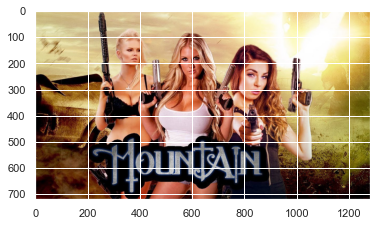

In [9]:
# Let us print another test image - say 100th image
plt.imshow(input_images[100]);
input_masks[100]

Observations:
- In the first image printed (input_images[10]), we have one face and so 1st element in the list giving cast information.
- In the second image printed (input_images[100]), we have three faces and so there are 3 elements in the list giving cast information.

### Step 1.3 - Mask detection model:

#### Step 1.3.1 - Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models

**- Defining hyper parameters -**

In [10]:
# Define the neccessary parameters

# Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
ALPHA = 1

# Ref: https://arxiv.org/pdf/1704.04861.pdf (Mobilenet paper shows that expected input image size is 224x224x3)
IMAGE_SIZE = 224

**- Input image pre-processing -**

Let us make our training and test split vectors from input images and mask arrays

In [11]:
# Preparing an empty array for masks
training_masks = np.zeros((no_of_images, IMAGE_SIZE, IMAGE_SIZE)) 

# Preparing an empty array for training images
training_images = np.zeros((no_of_images, IMAGE_SIZE, IMAGE_SIZE, 3))

for index in range(no_of_images):
    img = input_images[index]
    img = cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE))
    # Looks like there is one particular image with 4 channels and so an exception in resize
    # Lets add a try catch to handle that image
    try:
      img = img[:, :, :3]
    except:
      continue
    training_images[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in input_masks[index]:
        x1 = int(i["points"][0]['x'] * IMAGE_SIZE)
        x2 = int(i["points"][1]['x'] * IMAGE_SIZE)
        y1 = int(i["points"][0]['y'] * IMAGE_SIZE)
        y2 = int(i["points"][1]['y'] * IMAGE_SIZE)
        training_masks[index][y1:y2, x1:x2] = 1

**- Check shape of pre-processed images -**

Let us check the shape (dimension) of training_images and training_masks array

In [12]:
print ("Shape of training_images is -> ", training_images.shape)
print ("Shape of training_masks is -> ", training_masks.shape)

Shape of training_images is ->  (409, 224, 224, 3)
Shape of training_masks is ->  (409, 224, 224)


**- Let's visualize test images and masks -**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


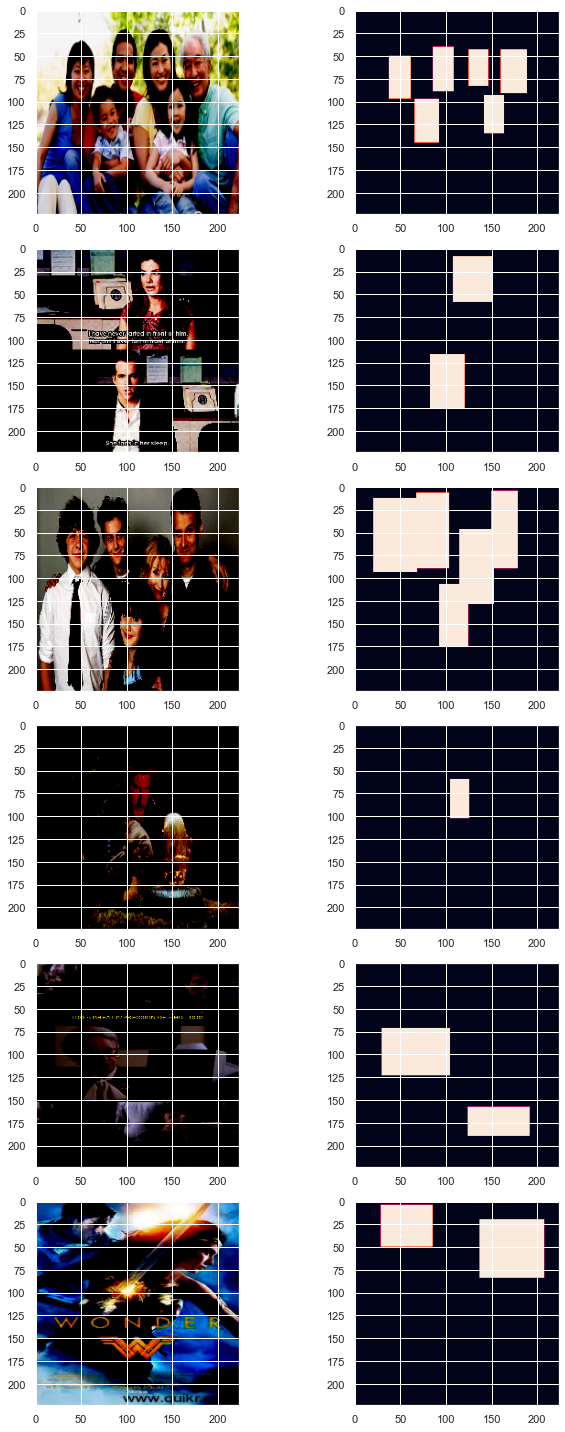

In [13]:
numOfRows = 6; # Number of samples to print
numOfCols = 2; # Two rows for display in each column. Index-0 for reference image and index-1 for related mask image

f, ax = plt.subplots(nrows=numOfRows, ncols=numOfCols, figsize=(10,20))
i=0;
for ro in range(4,10):
    ax[i, 0].imshow(training_images[ro]);
    ax[i, 1].imshow(training_masks[ro]);        
    i=i+1;
plt.tight_layout()
plt.show();

**- Let's split images/masks as train/test images -**

- Let us have 80:20 split for train and validation set
- Further from with in validation sample, lets split 80:20 for validation and test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(training_images, training_masks, test_size=0.2, random_state=1, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=1, shuffle=False)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape)
print("Shape of X_val -> ", X_val.shape, ", Shape of y_val -> ", y_val.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape)

Shape of X_train ->  (327, 224, 224, 3) , Shape of y_train ->  (327, 224, 224)
Shape of X_val ->  (65, 224, 224, 3) , Shape of y_val ->  (65, 224, 224)
Shape of X_test ->  (17, 224, 224, 3) , Shape of y_test ->  (17, 224, 224)


**- Let's design our model -**

In [15]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_SIZE, IMAGE_SIZE))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

On top of standard mobile, we have added 5 layers of skip connection + one layer of Conv2D with sigmoid activation + one layer of Reshape, in building our U-Net model.
- Note:
  - Mobilenet model is created with imagenet weights and we are not re-training any layer of existing mobile-net model. We are going to create MobileNet with 'imagenet' weights, so there by we are using transfer learning !
  - We will essentially have learnable parameters for last layer of Conv2D that we have added.

Let us create out model now...

In [16]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

model = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

Our UNet model is now ready !

#### Step 1.3.2 - Design your own Dice Coefficient and Loss function.

**Define dice coefficient**

In [17]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    # reduce_sum(), computes the sum of elements across dimensions of a tensor.
    # Since the 2nd arg, i.e., axis of reduce_sum() is 'None', it reduces all dimensions, 
    # and a tensor with a single element is returned.
    
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

**Define Loss function**

In [18]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

#### Step 1.3.3 - Train, tune and test the model.

**- Compile the model -**
- Define Optimizer and compile the model
- Define Callbacks

In [19]:
# To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Defining optimizer and compile
optimizer = Adam(lr=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

# We need not compute Recall() and Precision() in image recognition, especially when we have dice_coefficient.
# We are still doing it as a good practice.

In [20]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    EarlyStopping(monitor='val_loss', patience=2)
]

Train the Model

In [21]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

Epoch 1/5
11/11 [==============================] - 2480s 226s/step - loss: 1.9865 - dice_coefficient: 0.2534 - recall: 0.3145 - precision: 0.2145 - val_loss: 1.3163 - val_dice_coefficient: 0.3512 - val_recall: 0.4124 - val_precision: 0.4697 - lr: 0.0010
Epoch 2/5
11/11 [==============================] - 2304s 210s/step - loss: 1.1364 - dice_coefficient: 0.4375 - recall: 0.5424 - precision: 0.5025 - val_loss: 0.9991 - val_dice_coefficient: 0.4811 - val_recall: 0.5035 - val_precision: 0.5818 - lr: 0.0010
Epoch 3/5
11/11 [==============================] - 2351s 215s/step - loss: 0.9357 - dice_coefficient: 0.5199 - recall: 0.5501 - precision: 0.6016 - val_loss: 0.9088 - val_dice_coefficient: 0.5747 - val_recall: 0.6651 - val_precision: 0.5503 - lr: 0.0010
Epoch 4/5
11/11 [==============================] - 2309s 212s/step - loss: 0.8413 - dice_coefficient: 0.5681 - recall: 0.6150 - precision: 0.6117 - val_loss: 0.8443 - val_dice_coefficient: 0.5917 - val_recall: 0.6233 - val_precision: 0.60

#### Step 1.3.4 - Evaluate the model using testing data.

Lets evaluate the model

In [22]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 12s 12s/step - loss: 0.8167 - dice_coefficient: 0.5523 - recall: 0.5429 - precision: 0.6394


[0.8166580200195312,
 0.5522502660751343,
 0.5429209470748901,
 0.6393797993659973]

### Step 1.4 - Use the “Prediction image” as an input to your designed model and display the output of the image.

In [23]:
# Test image pre-processing
test_image_unscaled = cv2.imread(test_image)
image = cv2.resize(test_image_unscaled, (IMAGE_SIZE, IMAGE_SIZE))
test_image_scaled = preprocess_input(np.array(image, dtype=np.float32))
print ("Shape of preprocess'd image", test_image_scaled.shape)

# Test image prediction - Predict and prepare mask
# Our predict() API generate predictions for the input samples. So add an index at 0th position for a single image prediction.
image_array = np.array([test_image_scaled])
print ("Shape of image to be used for prediction", image_array.shape)

# Predict now
predict_image_arr = model.predict (x=image_array)

# Convert to grey scale
unscaled_pred_mask = (predict_image_arr[0] > 0.5) 

# Resize predicted image
scaled_pred_mask = cv2.resize(1.0 * unscaled_pred_mask, (IMAGE_SIZE,IMAGE_SIZE))

Shape of preprocess'd image (224, 224, 3)
Shape of image to be used for prediction (1, 224, 224, 3)


**Original test image**

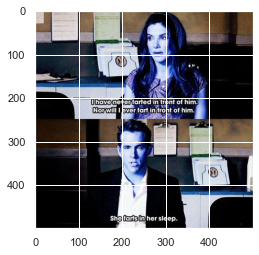

In [24]:
plt.imshow(test_image_unscaled);

**Predicted mask image**

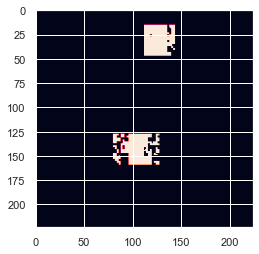

In [25]:
plt.imshow(scaled_pred_mask);

***Okay. Our model has detected two faces out of the test image, which is CORRECT ! :)***
- Note: 
  - Because of time and processor/system constraints, I've just run training for 5 epocs.
  - We can train the model for more epocs to get better prediction results.

### **PART - 2**

#### DOMAIN
Face recognition
#### CONTEXT
Company X intends to build a face identi!ication model to recognise human faces.
#### DATA DESCRIPTION
The dataset comprises of images and its mask where there is a human face.
#### PROJECT OBJECTIVE
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library.

#### TASK
In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not.

### Step 2.1 - Load the dataset and create the metadata

In [26]:
# All required imports
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model

**-- Setting up the project path --**

In [27]:
#### Setting the project path and input/test images paths####
project_path = "./Part-2"

input_zipfile = project_path + './Part 3 - Aligned Face Dataset from Pinterest.zip'
test_image_DwayneJohnson = project_path + './Part 2 - Test Image - Dwayne Johnson4.jpg'
test_image_BenedictCumberbatch = project_path + './Part 2- Test Image - Benedict Cumberbatch9.jpg'

**-- Lets extract the input zipfile --**

In [28]:
#### Extract the input zip file ####
with ZipFile(input_zipfile, 'r') as zip:
    print('Extracting all images...')
    zip.extractall()
    print ('Zip File extracted !')

Extracting all images...
Zip File extracted !


**-- Function to load images from extracted folder and map each image with person id --**

In [29]:
#### Define a function to load the images from the extracted folder and map each image with person id  ####

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg': #Just taking jpg images and avoiding any directories or temp files in processing
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

In [30]:
print ("Number of elements in metadata -> ", len(metadata))
print ("\nShape of metadata -> ", metadata.shape)
print ("\nMetadata contents are like,\n", metadata[0:10])

Number of elements in metadata ->  10770

Shape of metadata ->  (10770,)

Metadata contents are like,
 [PINS\pins_Aaron Paul\Aaron Paul0_262.jpg
 PINS\pins_Aaron Paul\Aaron Paul101_247.jpg
 PINS\pins_Aaron Paul\Aaron Paul101_248.jpg
 PINS\pins_Aaron Paul\Aaron Paul101_249.jpg
 PINS\pins_Aaron Paul\Aaron Paul103_217.jpg
 PINS\pins_Aaron Paul\Aaron Paul113_228.jpg
 PINS\pins_Aaron Paul\Aaron Paul114_271.jpg
 PINS\pins_Aaron Paul\Aaron Paul116_240.jpg
 PINS\pins_Aaron Paul\Aaron Paul117_213.jpg
 PINS\pins_Aaron Paul\Aaron Paul119_219.jpg]


Okay, Good to see that the input images count is 10770, which is same as the count mentioned in the problem definition !

### Step 2.2 - Check some samples of metadata.

**-- Function to load images from metadata --**

In [31]:
#### Function to load an image ####
#### Define a function to load image from the metadata ####
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

**-- Loading sample image --**

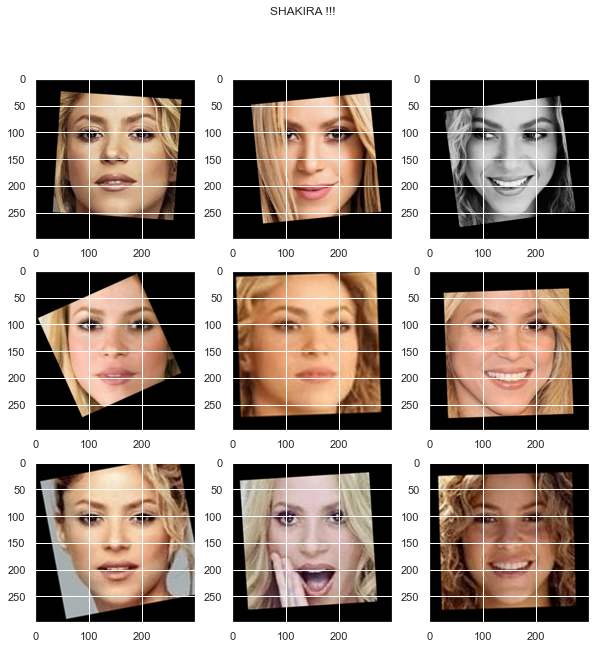

In [32]:
#### Let us load some sample images using the function "load_image" ####
# Lets load some images of Shakira :)

plt.figure(figsize=(10,10))
plt.suptitle('SHAKIRA !!!')
plt.subplot(331)
plt.imshow(load_image('PINS\pins_shakira\shakira0.jpg'));
plt.subplot(332)
plt.imshow(load_image('PINS\pins_shakira\shakira1.jpg')) ;
plt.subplot(333)
plt.imshow(load_image('PINS\pins_shakira\shakira2.jpg'));
plt.subplot(334)
plt.imshow(load_image('PINS\pins_shakira\shakira3.jpg')) ;
plt.subplot(335)
plt.imshow(load_image('PINS\pins_shakira\shakira4.jpg'));
plt.subplot(336)
plt.imshow(load_image('PINS\pins_shakira\shakira5.jpg')) ;
plt.subplot(337)
plt.imshow(load_image('PINS\pins_shakira\shakira6.jpg')) ;
plt.subplot(338)
plt.imshow(load_image('PINS\pins_shakira\shakira7.jpg')) ;
plt.subplot(339)
plt.imshow(load_image('PINS\pins_shakira\shakira8.jpg')) ;

### Step 2.3 - Load the pre-trained model and weights.

**-- VGG Face model --**

In [33]:
# Let us create the structure of VGG face model !

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

**-- Load the model and given weight file named "vgg_face_weights.h5" --**

In [34]:
model = vgg_face()
model.load_weights(project_path + './Part 3 - vgg_face_weights.h5')

**-- Get vgg_face_descriptor --**

In [35]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Step 2.4 - Generate Embedding vectors for each face in the dataset

**-- Generate embeddings for each image in the dataset (list of images in metadata) --**

In [36]:
## Logic: 
## 1. Iterate through metadata (list with input image filenames)
## 2. Load the image and create embeddings for each image using vgg_face_descriptor.predict() 
## 3. Store embeddings for each input image in a list by name embeddings
## Note: Final embedding from the model for each image is of size 2622 (Based on last Convolution2D layer in the model)

embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


Let us have a look at sample embeddings value for input images with,
- index 0 (first image), 
- index 1 (second image) and 
- index 10769 (last image)

In [37]:
print ("Embeddings for image in index-0 of shape", embeddings[0].shape, " is,\n", embeddings[0])
print ("Embeddings for image in index-1 of shape", embeddings[1].shape, " is,\n", embeddings[1])
print ("Embeddings for image in index-10769 of shape", embeddings[10769].shape, " is,\n", embeddings[10769])

Embeddings for image in index-0 of shape (2622,)  is,
 [ 0.03170304 -0.0150513  -0.01243402 ...  0.00043139  0.00219081
 -0.00908097]
Embeddings for image in index-1 of shape (2622,)  is,
 [ 0.03497701 -0.00105061 -0.01248934 ... -0.0105309   0.00179322
  0.02439155]
Embeddings for image in index-10769 of shape (2622,)  is,
 [ 0.01772302  0.01064051  0.01995194 ... -0.0261843   0.03288927
  0.0488265 ]


### Step 2.5 - Build distance metrics for identifying the distance between two given images

**-- Function to calculate distance between given 2 pairs of images --**
- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [38]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Let us write a function called "show_pair(image1, image2)" that will,
- Take 2 images as input
- Calls distance() function and
- Plots the images and shows the distance

In [39]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

Lets call show_pair() function with one 'Positive pair' and 'Negative pair'

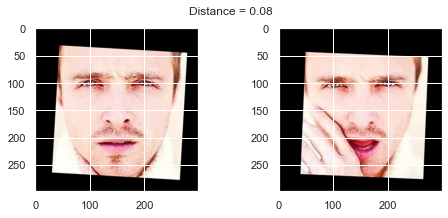

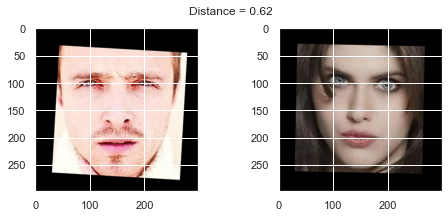

In [40]:
show_pair(1, 2) # Positive pair (Distance value will be less)
show_pair(1, 200) # Negative pair (Distance value will be more)

**-- Create train and test sets --**
- 90% of input data is training data and
- 10% of input data is test data

In [41]:
# Every 9th element in metadata goes to test data and rest goes into train data
train_idx = np.arange(metadata.shape[0]) % 9 != 0     
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Assign train_idx images to X_train, test_idx images to X_test
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

# Get the target image names from metadata for x_train (with train_idx) and x_test (test_idx). 
# Put the same in y_train and y_test
targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

Lets check the shape of train and test images.

In [42]:
print('X_train shape -> ', X_train.shape[0], X_train.shape[1])
print('y_train shape -> ', y_train.shape[0])
print('X_test shape -> ', X_test.shape[0], X_test.shape[1])
print('y_test shape -> ', y_test.shape[0])

X_train shape ->  9573 2622
y_train shape ->  9573
X_test shape ->  1197 2622
y_test shape ->  1197


In [43]:
len(np.unique(y_test)), len(np.unique(y_train))

(100, 100)

- Above data shows that we have all 100 categories of face images in both train and test data set. 
- We are all set good !

**-- Let us encode the target labels, using LabelEncoder --**

In [44]:
# Create an object of LabelEncoder
le = LabelEncoder()

# Do fit_transform of target values of train data
y_train_encoded = le.fit_transform(y_train)

# Do fit_transform of target values of test data
y_test_encoded = le.fit_transform(y_test)

Let us print and understand how LabelEncoder has put our target data

In [45]:
# Class names (we must have 100 categories here)
print("Number of target class types is -> ", len(le.classes_))
print("\n Target classes are\n", le.classes_)

Number of target class types is ->  100

 Target classes are
 ['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman_'
 'pins_Neil Patrick Harris' 'pin

In [46]:
# Let us print the encoded y_train and y_test data
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)
len(np.unique(y_train_encoded)), len(np.unique(y_test_encoded))

y_train_encoded :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


(100, 100)

Okay.. So we have got all 100 classes/categories starting from 0 to 99 encoded values, in each target (train and test)

**-- Standardize the input feature values, using StandardScaler --**

In [47]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

print('X_train_std shape -> ', X_train_std.shape)
print('y_train_encoded shape -> ', y_train_encoded.shape)
print('X_test_std shape -> ', X_test_std.shape)
print('y_test_encoded shape -> ', y_test_encoded.shape)

X_train_std shape ->  (9573, 2622)
y_train_encoded shape ->  (9573,)
X_test_std shape ->  (1197, 2622)
y_test_encoded shape ->  (1197,)


### Step 2.6 - Use PCA for dimensionality reduction

- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [48]:
# Let us reduce the input feature dimension from size 2622 to 128 !
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print('X_train shape before PCA -> ', X_train_std.shape)
print('X_test shape before PCA -> ', X_test_std.shape)

print('X_train shape after PCA -> ', X_train_pca.shape)
print('X_test shape after PCA -> ', X_test_pca.shape)

X_train shape before PCA ->  (9573, 2622)
X_test shape before PCA ->  (1197, 2622)
X_train shape after PCA ->  (9573, 128)
X_test shape after PCA ->  (1197, 128)


Okay. So we now see that feature embedding size has come down significantly from 2622 to 128 as part of PCA ! 

### Step 2.7 - Build an SVM classifier in order to map each image to its right person.

- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [49]:
clf = SVC(kernel='rbf', gamma='scale', random_state=1)
clf.fit(X_train_pca, y_train_encoded)

SVC(random_state=1)

Let us evaluate how good is our model with test data verifications !

In [50]:
y_predict = clf.predict(X_test_pca)
print('y_predict of shape', y_predict.shape, ' : ',y_predict)
print('y_test_encoded of shape', y_test_encoded.shape, ' : ',y_test_encoded)

y_predict of shape (1197,)  :  [ 0  0  0 ... 99 99 99]
y_test_encoded of shape (1197,)  :  [ 0  0  0 ... 99 99 99]


Let us score model performance !

In [51]:
accuracy_score(y_test_encoded, y_predict)

0.9598997493734336

### Step 2.8 - Import the the test image. Display the image. Use the SVM trained model to predict the face.

1. Import test images
2. Display test images
3. Use trained SVM model to predict the face (class of images)

In [52]:
def predict_person(test_input_image, debug=False):
    # Load the image
    raw_image = load_image(test_input_image)

    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    raw_image_normalized = (raw_image / 255.).astype(np.float32)
    raw_image_normalized_resized = cv2.resize(raw_image_normalized, dsize = (224,224))
    if (debug):
        print("Shape of normalized and resized image is", raw_image_normalized_resized.shape)

    # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(raw_image_normalized_resized, axis=0))[0]
    if (debug):
        print("Shape of embedding vector", embedding_vector.shape)

    embedding_vector = np.expand_dims(embedding_vector, axis=0)
    if (debug):
        print("Shape of embedding vector", embedding_vector.shape)

    # Standarize features
    embedding_vector_std = scaler.transform(embedding_vector)
    if (debug):
        print('embedding_vector_std shape : ({0},{1})'.format(embedding_vector_std.shape[0], embedding_vector_std.shape[1]))

    # Reduce the input feature dimension from size 2622 to 128 !
    embedding_vector_pca = pca.transform(embedding_vector_std)

    # Run SVC classifier to predict the output class
    predicted_class_vector = clf.predict(embedding_vector_pca)

    # Lets get the class name from predicted class vector
    predicted_class_name = le.inverse_transform(predicted_class_vector)

    plt.imshow(raw_image_normalized_resized)
    plt.title(f'Person identified as -> {predicted_class_name}');

Running prediction on 1st test image

Shape of normalized and resized image is (224, 224, 3)
Shape of embedding vector (2622,)
Shape of embedding vector (1, 2622)
embedding_vector_std shape : (1,2622)


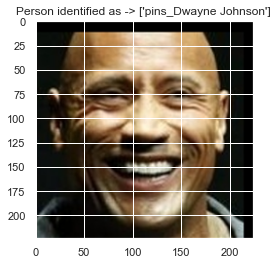

In [53]:
predict_person(test_image_DwayneJohnson, True)

Running prediction on 2nd test image

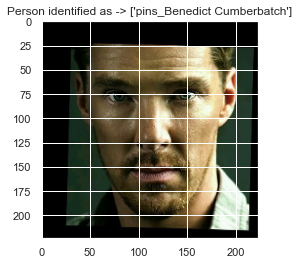

In [54]:
predict_person(test_image_BenedictCumberbatch)

**Hurrey ! We are able to predict both test images successfully ! :)**